In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from sklearn.model_selection import StratifiedKFold
from keras import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [2]:
train = pd.read_csv('../input/dacon7/train.csv')
test = pd.read_csv('../input/dacon7/test.csv')
sub = pd.read_csv('../input/dacon7/submission.csv')

In [3]:
# drop columns
train2 = train.drop(['id','digit','letter'],1)
test2 = test.drop(['id','letter'],1)

In [4]:
# convert pandas dataframe to numpy array
train2 = train2.values
test2 = test2.values

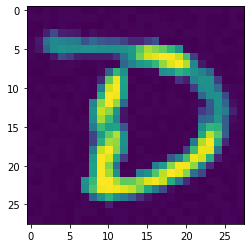

In [5]:
plt.imshow(train2[100].reshape(28,28))

In [6]:
# reshape
train2 = train2.reshape(-1,28,28,1)
test2 = test2.reshape(-1,28,28,1)

In [7]:
# data normalization
train2 = train2/255.0
test2 = test2/255.0

In [8]:
# ImageDatagenerator & data augmentation
idg = ImageDataGenerator(height_shift_range=(-1,1),width_shift_range=(-1,1))
idg2 = ImageDataGenerator()

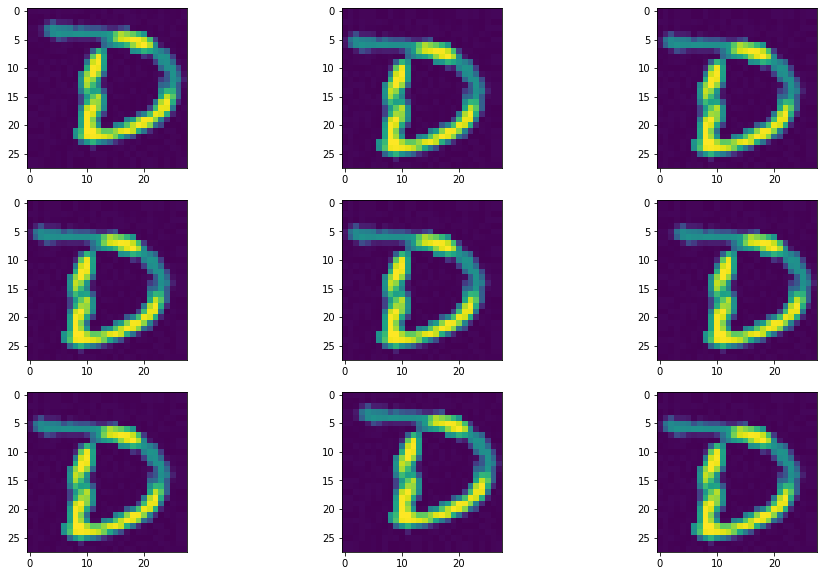

In [9]:
# show augmented image data
sample_data = train2[100].copy()
sample = expand_dims(sample_data,0)
sample_datagen = ImageDataGenerator(height_shift_range=(-1,1), width_shift_range=(-1,1))
sample_generator = sample_datagen.flow(sample, batch_size=1)

plt.figure(figsize=(16,10))

for i in range(9) : 
    plt.subplot(3,3,i+1)
    sample_batch = sample_generator.next()
    sample_image=sample_batch[0]
    plt.imshow(sample_image.reshape(28,28))

In [10]:
# cross validation
skf = StratifiedKFold(n_splits=40, random_state=42, shuffle=True)

In [11]:
%%time

reLR = ReduceLROnPlateau(patience=100,verbose=1,factor=0.5) #learning rate scheduler
es = EarlyStopping(patience=160, verbose=1)

val_loss_min = []
result = 0
nth = 0

for train_index, valid_index in skf.split(train2,train['digit']) :
    
    mc = ModelCheckpoint('best_cvision.h5',save_best_only=True, verbose=1)
    
    x_train = train2[train_index]
    x_valid = train2[valid_index]    
    y_train = train['digit'][train_index]
    y_valid = train['digit'][valid_index]
    
    train_generator = idg.flow(x_train,y_train,batch_size=8)
    valid_generator = idg2.flow(x_valid,y_valid)
    test_generator = idg2.flow(test2,shuffle=False)
    
    model = Sequential()
    
    model.add(Conv2D(16,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(10,activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.002,epsilon=None),metrics=['acc'])
    
    learning_history = model.fit_generator(train_generator,epochs=2000, validation_data=valid_generator, callbacks=[es,mc,reLR])
    
    # predict
    model.load_weights('best_cvision.h5')
    result += model.predict_generator(test_generator,verbose=True)/40
    
    # save val_loss
    hist = pd.DataFrame(learning_history.history)
    val_loss_min.append(hist['val_loss'].min())
    
    nth += 1
    print(nth, '번째 학습을 완료했습니다.')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2000
250/250 [==============================] - 8s 12ms/step - loss: 2.8629 - acc: 0.1179 - val_loss: 4.3258 - val_acc: 0.0962

Epoch 00001: val_loss improved from inf to 4.32582, saving model to best_cvision.h5
Epoch 2/2000
250/250 [==============================] - 2s 9ms/step - loss: 2.2584 - acc: 0.2091 - val_loss: 3.0961 - val_acc: 0.0962

Epoch 00002: val_loss improved from 4.32582 to 3.09610, saving model to best_cvision.h5
Epoch 3/2000
226/250 [==========================>...] - ETA: 0s - loss: 1.9600 - acc: 0.2983

KeyboardInterrupt: 

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        1

In [ ]:
sub['digit'] = result.argmax(1)

# pytorch

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms

In [38]:
BATCH=64
EPOCHS=20

In [21]:
train=pd.read_csv('../input/dacon7/train.csv')
test=pd.read_csv('../input/dacon7/test.csv')
submit=pd.read_csv('../input/dacon7/submission.csv')

In [22]:
X_train=train.drop(['id','digit','letter'],axis=1)
X_test=test.drop(['id','letter'],axis=1)
y_train=train['digit'].values

In [24]:
X_train=X_train.values.reshape(-1,1,28,28)
X_test=X_test.values.reshape(-1,1,28,28)

In [25]:
Transforms=transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomAffine(degrees=0,translate=(1/28,1/28))
])

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


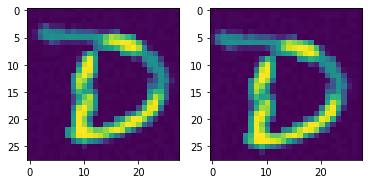

In [26]:
plt.subplot(1,2,1)
plt.imshow(X_train[100].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(transforms.RandomAffine(degrees=0,translate=(1/28,1/28))(torch.from_numpy(X_train[100]).type(torch.FloatTensor)).numpy().reshape(28,28))

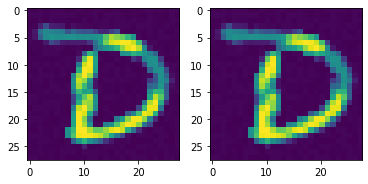

In [27]:
plt.subplot(1,2,1)
plt.imshow(X_train[100].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(transforms.RandomAffine(degrees=0,shear=[-1,1,-1,1])(torch.from_numpy(X_train[100]).type(torch.FloatTensor)).numpy().reshape(28,28))

In [28]:
np.sum(X_train[100].reshape(28,28)-\
transforms.RandomAffine(degrees=0,shear=[-1,1,-1,1])(torch.from_numpy(X_train[100]).type(torch.FloatTensor)).numpy().reshape(28,28))

0.0

In [36]:
class GetData(Dataset):
    def __init__(self,X,Y=None,Transform=Transforms,mode='train'):
        self.X=torch.from_numpy(X).type(torch.FloatTensor)
        if Y is not None:
            self.Y=torch.from_numpy(Y).type(torch.LongTensor)
        else:
            print('No label')
        self.Transform=Transform
        
    def __len__(self):
        return len(self.X)

    def __getitem(self,idx):
        if mode=='train':
            return self.Transform(self.X[idx]),self.Y[idx]
        else:
            return transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])(self.X[idx])

In [37]:
trainset=GetData(X_train,y_train,mode='train')
testset=GetData(X_test,mode='test')

No label


In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH,shuffle=True)
testloader=DataLoader(testset,batch_size=BATCH)

### summary

In [ ]:
# https://github.com/sksq96/pytorch-summary
!pip install torchsummary

from torchsummary import summary

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.l1=nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1),
        nn.ReLU(inplace=True), # inplace는 결과값을 새로운 변수에 저장하고, 기존의 데이터를 대체한다.
        nn.BatchNorm2d(num_features=16),
        nn.Dropout(p=0.3))
        
        self.l2=nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=32),
        nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5,padding=2,stride=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=32),
        nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5,padding=2,stride=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=32),
        nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5,padding=2,stride=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=32),
        nn.MaxPool2d(kernel_size=3,stride=3),
        nn.Dropout(p=0.3))
        
        self.l3=nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=64),
        nn.Conv2d(in_channels=64,out_channels=64,kernel_size=5,stride=1,padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=64),
        nn.MaxPool2d(kernel_size=3,stride=3),
        nn.Dropout(p=0.3))
    
        self.l4=nn.Sequential(
        nn.Linear(in_features=576,out_features=128),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(num_features=128),
        nn.Dropout(p=0.3),
        nn.Linear(in_features=128,out_features=64),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(num_features=64),
        nn.Dropout(p=0.3),
        nn.Linear(in_features=64,out_features=10),
        nn.Softmax(dim=1))
        
    def forward(self,x):
        output=self.l1(x)
        output=self.l2(output)
        output=self.l3(output)
        output=output.view(output.size(0),-1) # flatten
        output=self.l4(output)
        return output

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=CNN().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
           Dropout-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
              ReLU-6           [-1, 32, 28, 28]               0
       BatchNorm2d-7           [-1, 32, 28, 28]              64
            Conv2d-8           [-1, 32, 28, 28]          25,632
              ReLU-9           [-1, 32, 28, 28]               0
      BatchNorm2d-10           [-1, 32, 28, 28]              64
           Conv2d-11           [-1, 32, 28, 28]          25,632
             ReLU-12           [-1, 32, 28, 28]               0
      BatchNorm2d-13           [-1, 32, 28, 28]              64
           Conv2d-14           [-1, 32,

In [ ]:
criterion=nn.

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    tr_loss=0.0
    
    for i,(images,labels) in enumerate(trainloader):
        images=images.to(device)
        labels=labels.to(device)
        
        output=model(images)
        
        loss=